In [1]:
# Imports

import time
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer

In [2]:
# Notebook settings
%matplotlib notebook

In [3]:
scope = cw.scope()
target = cw.target(scope)

In [4]:
# setup scope parameters
scope.gain.gain = 45
scope.adc.samples = 20000
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x1"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

target.key_cmd = ""
target.output_cmd = ""

In [5]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None

In [6]:
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simpleserial-rsa'))
hex_file = os.path.join(firmware_dir, r'simpleserial-rsa-CW303.hex')

In [7]:
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 11857 bytes


In [8]:
# Aquiring example data
traces = []
textins = [
    '00000000000000000000000000008000', # 1000 0000 0000 0000
    '0000000000000000000000000000c000', # 1100 0000 0000 0000
    '0000000000000000000000000000e000', # 1110 0000 0000 0000
    '00000000000000000000000000008140', # 1000 0001 0100 0000
    '0000000000000000000000000000ABE2', # 1010 1011 1110 0010
    '0000000000000000000000000000ABE3'  # 1010 1011 1110 0011
    
]

# Capture two traces for each input: reference and test
textins = [x for t in textins for x in (t, t)]

print(textins)

target.init()

for textin in tqdm_notebook(textins, desc='Capturing traces'):
    target.reinit()

    target.loadInput(textin)
    target.loadEncryptionKey(textin)

    scope.arm()
    target.go()

    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)

    try:
        ret = scope.capture()
        if ret:
            print('Timeout happened during acquisition')
    except IOError as e:
        print('IOError: %s' % str(e))

    trace = scope.getLastTrace()
    
    traces.append(trace)

['00000000000000000000000000008000', '00000000000000000000000000008000', '0000000000000000000000000000c000', '0000000000000000000000000000c000', '0000000000000000000000000000e000', '0000000000000000000000000000e000', '00000000000000000000000000008140', '00000000000000000000000000008140', '0000000000000000000000000000ABE2', '0000000000000000000000000000ABE2', '0000000000000000000000000000ABE3', '0000000000000000000000000000ABE3']


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdDYXB0dXJpbmcgdHJhY2VzJywgbWF4PTEyLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


<IPython.core.display.Javascript object>


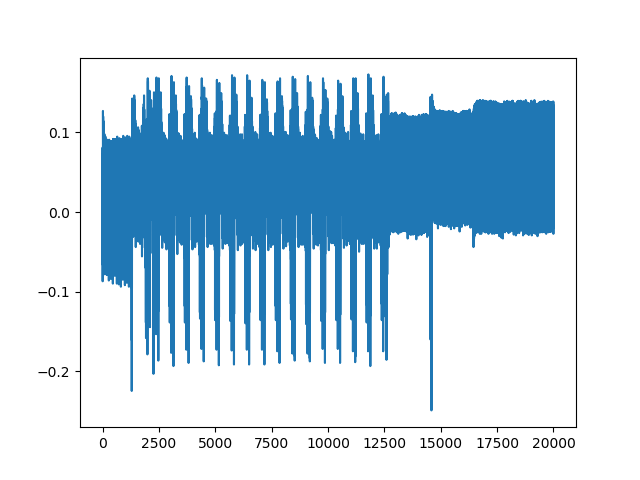

<IPython.core.display.Javascript object>


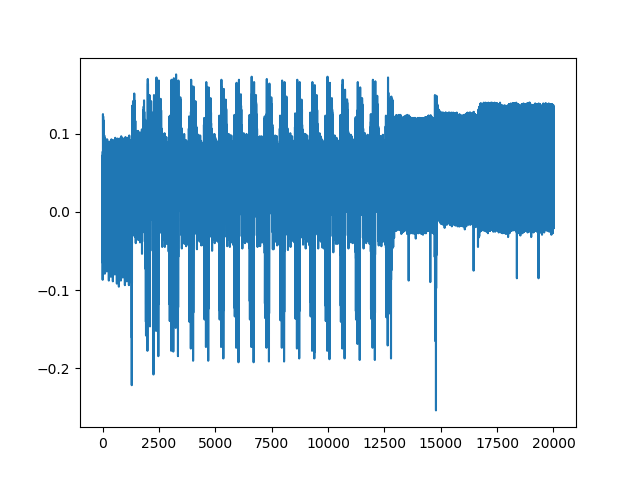

<IPython.core.display.Javascript object>


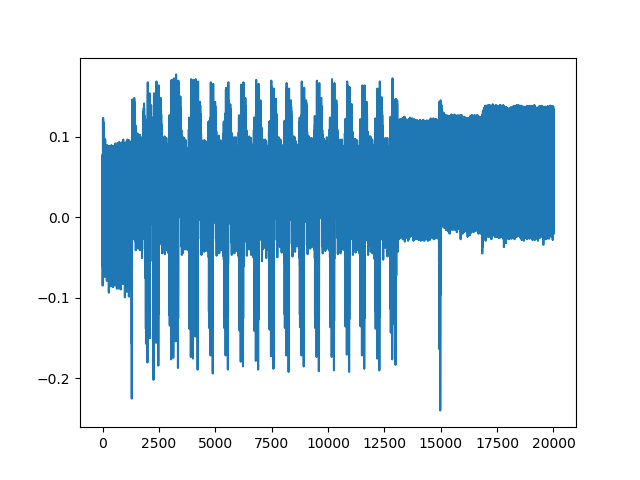

In [9]:
plt.figure(1)
plt.plot(traces[0])
plt.show()
plt.figure(2)
plt.plot(traces[2])
plt.show()
plt.figure(3)
plt.plot(traces[4])
plt.show()

<IPython.core.display.Javascript object>


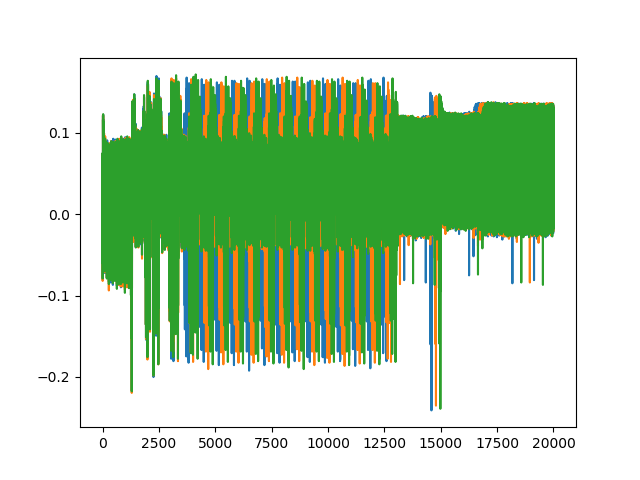

In [70]:
plt.figure(4)
plt.plot(traces[0])
plt.plot(traces[2])
plt.plot(traces[4])
plt.show()

<IPython.core.display.Javascript object>


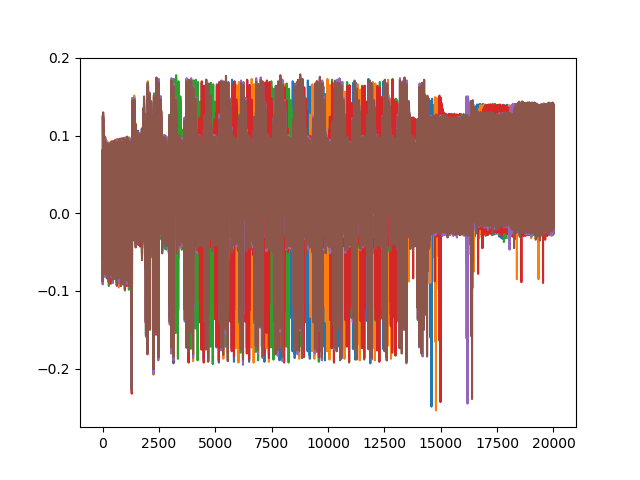

In [18]:
# show example traces
plt.figure(5)
for t in range(0, len(traces), 2):
    plt.plot(traces[t])
plt.show()

<IPython.core.display.Javascript object>


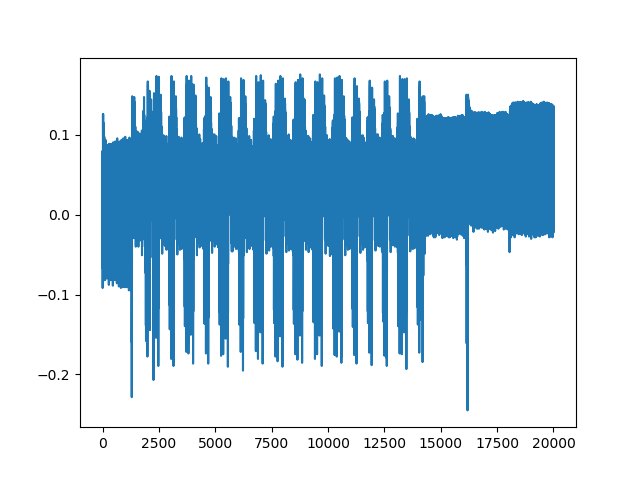

In [24]:
plt.figure(6)
plt.plot(traces[8])
plt.show()

In [22]:
ref_start = 1899
ref_length = 2107-ref_start
reference = np.asarray(traces[2], dtype=np.float64) # ...8000
attacked = np.asarray(traces[8], dtype=np.float64) # ...ABE2

#autocorr = np.correlate(attacked, attacked, mode='full')

rsa_one = reference[ref_start:(ref_start+ref_length)]

diffs = []
for i in range(len(attacked) - ref_length):
    diff = attacked[i:(i + ref_length)] - rsa_one
    diffs.append(np.sum(abs(diff)))

corr_data = np.correlate(rsa_one, attacked, mode='full')[::-1]

<IPython.core.display.Javascript object>


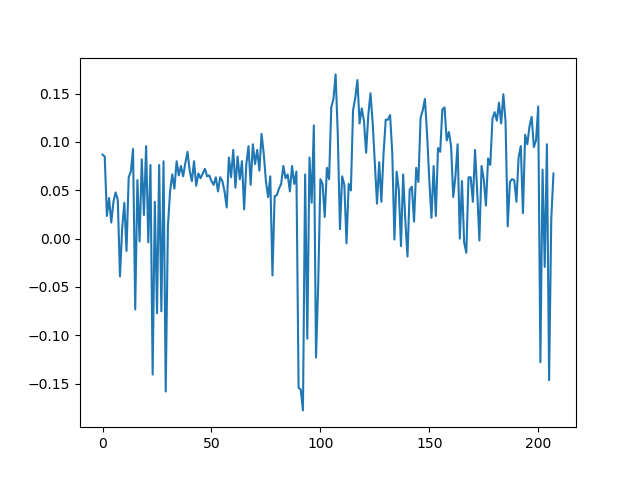

In [28]:
plt.figure(7)
plt.plot(rsa_one)
plt.show()

<IPython.core.display.Javascript object>


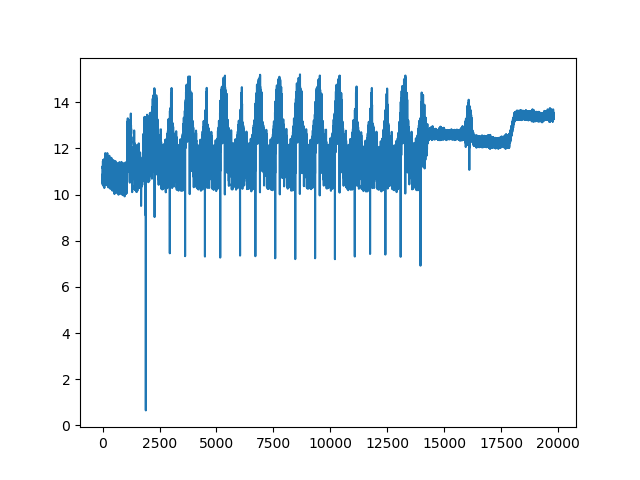

In [30]:
plt.figure(8)
plt.plot(diffs)
plt.show()

<IPython.core.display.Javascript object>


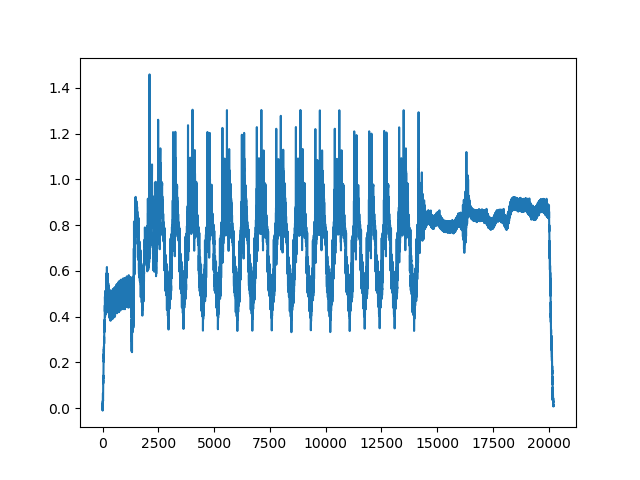

In [31]:
plt.figure(9)
plt.plot(corr_data)
plt.show()

In [27]:
diffs = np.array(diffs)

loc = np.where(diffs < 8)
loc = loc[0]

print(loc)

# Sometimes MSB cannot be discovered, because square-reduce of 1 has a different fingerprint than square-reduce of non-1
deltas = []
for i in range(len(loc) - 1):
    delta = loc[i+1] - loc[i]
    deltas.append(delta)
    
print(deltas)

recovered = 0
bitnum = 16
for i in range(len(deltas)):
    bitnum -= 1
    if(deltas[i] > 671):
        recovered |= 1 << bitnum
        
print("Key      = {:016b}".format(recovered))
print("Expected = {:016b}".format(0xABE2))

[ 1899  2952  3623  4494  5165  6036  6707  7578  8458  9329 10200 11071
 11742 12413 13084 13955]
[1053, 671, 871, 671, 871, 671, 871, 880, 871, 871, 871, 671, 671, 671, 871]
Key      = 1010101111100010
Expected = 1010101111100010


In [21]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()